# OpenRAO in pyPowsybl 

In this notebook, you will learn how to use OpenRAO with pypowsybl to optimize a network situation given available remedial actions.

The first step is to install pypowsybl and import the library.

In [1]:
#pip install pypowsybl==1.12.0

In [2]:
import pypowsybl as pp
from pypowsybl.rao import Parameters as RaoParameters

We will consider a 12 bus example network in this notebook.

In [3]:
n12 = pp.network.load('./data/rao/12_node_network.uct')

By drawing the network area diagram, you can get a better understanding of the substations and branches in the network.

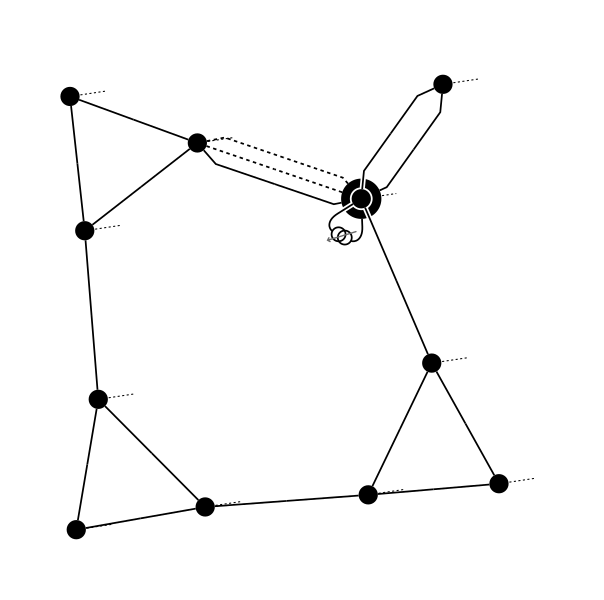

In [4]:
n12.get_network_area_diagram()

## 1 - Simple N case overload

To check the initial situation we can just run a loadflow on the network and redraw the network.

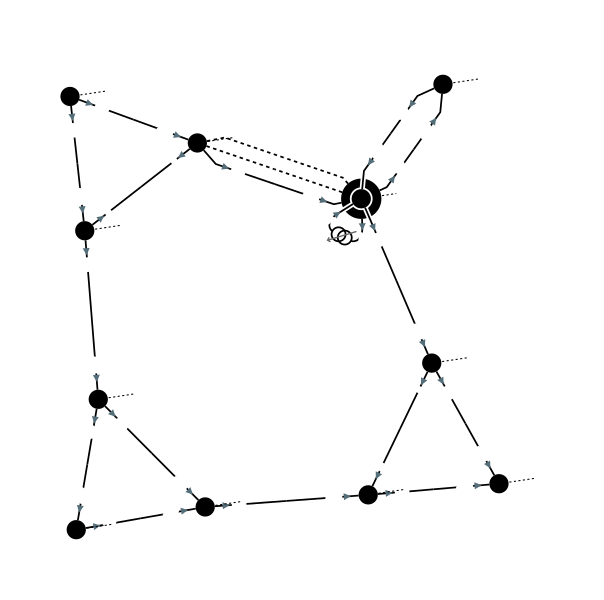

In [5]:
pp.loadflow.run_ac(n12)
n12.get_network_area_diagram()

We can see the initial flow on the line NNL2AA1 and BBE3AA1 is 500MW. However the PATL is only 410 MW so there is an overload on this line.
To solve it we can for instance close one of the other lines between NNL2AA1 and BBE3AA1.

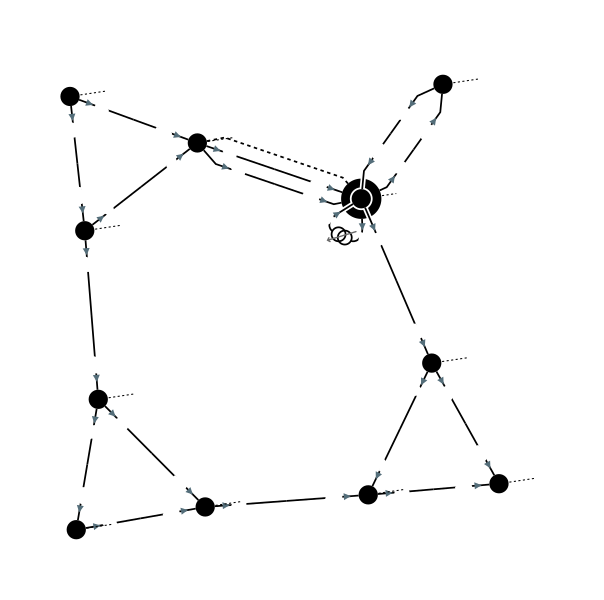

In [6]:
n12.connect("NNL2AA1  BBE3AA1  2")
pp.loadflow.run_ac(n12)
n12.get_network_area_diagram()

As we can see, the new flow is 270MW, and **the overload has been solved**.

This solution can be found by the RAO. For this we will need some input files: the network (which we already have), and a crac file which will contain information about available remedial actions, and CNECs (critical network elements and contingencies). For more information on the crac input, you can check this page: https://powsybl.readthedocs.io/projects/openrao/en/stable/input-data/crac/json.html

In [7]:
# prepare inputs
n12 = pp.network.load('./data/rao/12_node_network.uct')
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(n12, "./data/rao/N_case_crac.json")
rao_parameters = RaoParameters()
rao_parameters.load_from_file_source("./data/rao/rao_parameters.json")
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
#run rao
raoResult = rao_runner.run(n12, rao_parameters)
result_json = raoResult.to_json()

2025-09-08 09:21:13,700 - WARNING - Running RAO using Open RAO version 6.7.0-SNAPSHOT from git commit ea80e63634c4ff2038696d4ca76f99ed861d1263.
2025-09-08 09:21:13,701 - WARNING - Non re-optimizing curative range actions is deprecated. Curative range actions re-optimization will be mandatory in a future OpenRAO version.
2025-09-08 09:21:13,701 - WARNING - A threshold for the flowCnec NNL2AA1  BBE3AA1  1 - preventive is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 09:21:13,702 - WARNING - A threshold for the flowCnec NNL2AA1  BBE3AA1  1 - preventive is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 09:21:13,703 - WARNING - Network {CC0 SC0}: 11 generators have been discarded from active power control because of a targetP equals 0
2025-09-08 09:21:13,7

Let's examine the results of RAO.

In [8]:
result_json

{'type': 'RAO_RESULT',
 'version': '1.8',
 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao',
 'computationStatus': 'default',
 'executionDetails': 'The RAO only went through first preventive',
 'costResults': {'initial': {'functionalCost': 90.0,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'preventive': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'outage': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'curative': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}}},
 'computationStatusMap': [],
 'flowCnecResults': [{'flowCnecId': 'NNL2AA1  BBE3AA1  1 - preventive',
   'initial': {'ampere': {'margin': -129.99, 'side1': {'flow': 721.77}},
    'megawatt': {'margin': -90.0, 'side1': {'flow': 500.0}}},
   'preventive': {'ampere': {'margin': 201.67, 'side1': {'flow': 390.11}},
    'megawatt': {'margin': 139.73, 'side1': {'flow': 270.27}}}}],
 'a

We can see that initially there was a cost of +90 (which corresponds to a worst margin of -90MW, ie a worst overload of 90MW). Then after preventive actions, a cost of -139.73 (ie a worst margin of +139.73MW).
Then we have the results per flow cnec. And finally we have the information of what actions were applied. Here we applied the action "close NL2 BE3 2" in the preventive state.
For more information about the RaoResult, you can check this page: https://powsybl.readthedocs.io/projects/openrao/en/stable/output-data/rao-result.html

## 2 - N-1 outage overload

In this next case we added a flow cnec which limits the flow on the line NNL2AA1 and BBE3AA1 to 450MW, after the loss of the line between DDE2AA1 and DDE3AA1, at the outage instant (ie before we have the time to apply any actions - for more information about instants in OpenRAO you can check this page: https://powsybl.readthedocs.io/projects/openrao/en/stable/castor/rao-steps.html).
This flow cnec will be overloaded even with the application of the topological action. Thankfully, we also added a preventive PST to solve the new constraint.

In [9]:
# prepare inputs
n12 = pp.network.load('./data/rao/12_node_network.uct')
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(n12, "./data/rao/N-1_case_crac_outage.json")
rao_parameters = RaoParameters()
rao_parameters.load_from_file_source("./data/rao/rao_parameters.json")
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
#run rao
raoResult = rao_runner.run(n12, rao_parameters)
result_json = raoResult.to_json()

2025-09-08 09:21:13,824 - ERROR - BBE1AA1  BBE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,824 - ERROR - BBE1AA1  BBE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,825 - ERROR - FFR1AA1  FFR2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,825 - ERROR - FFR1AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,825 - ERROR - FFR2AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,825 - ERROR - DDE1AA1  DDE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,826 - ERROR - DDE1AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,826 - ERROR - DDE2AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,826 - ERROR - NNL1AA1  NNL2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,827 - ERROR - NNL1AA1  NNL

In [10]:
result_json

{'type': 'RAO_RESULT',
 'version': '1.8',
 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao',
 'computationStatus': 'default',
 'executionDetails': 'The RAO only went through first preventive',
 'costResults': {'initial': {'functionalCost': 133.3,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'preventive': {'functionalCost': -187.22,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'outage': {'functionalCost': -187.22,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'curative': {'functionalCost': -187.22,
   'virtualCost': {'sensitivity-failure-cost': 0.0}}},
 'computationStatusMap': [],
 'flowCnecResults': [{'flowCnecId': 'NNL2AA1  BBE3AA1  1 - Contingency DE2 DE3 - outage',
   'initial': {'ampere': {'margin': -192.55, 'side1': {'flow': 842.07}},
    'megawatt': {'margin': -133.3, 'side1': {'flow': 583.3}}},
   'preventive': {'ampere': {'margin': 270.21, 'side1': {'flow': 379.3}},
    'megawatt': {'margin': 187.22, 'side1': {'flow

This time the initial worse overload was 133MW on the outage cnec. If you check the logs carefully (currently we cannot separate the OLF logs from the OpenRAO logs in pypowsybl which makes it a bit hard to read), you can see that we initially tried to solve the constraints with just the PST (root leaf), and still had an overload of 42MW.
Then we tried applying the topological action and reoptimized the pst, and ended up with a worst margin of 187MW!  

## 3 - N-1 curative overload

In this final case, we will also check the flow on line BE1 BE2, but this time at the curative instant. We will change the usage rule on the PST to be able to move it in curative to be able to solve the new constraint we have on the line.

In [11]:
# prepare inputs
n12 = pp.network.load('./data/rao/12_node_network.uct')
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(n12, "./data/rao/N-1_case_crac_curative.json")
rao_parameters = RaoParameters()
rao_parameters.load_from_file_source("./data/rao/rao_parameters.json")
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
#run rao
raoResult = rao_runner.run(n12, rao_parameters)
result_json = raoResult.to_json()

2025-09-08 09:21:13,998 - ERROR - BBE1AA1  BBE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,999 - ERROR - BBE1AA1  BBE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,999 - ERROR - FFR1AA1  FFR2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:13,999 - ERROR - FFR1AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,000 - ERROR - FFR2AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,000 - ERROR - DDE1AA1  DDE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,001 - ERROR - DDE1AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,001 - ERROR - DDE2AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,001 - ERROR - NNL1AA1  NNL2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,001 - ERROR - NNL1AA1  NNL

In [12]:
result_json

{'type': 'RAO_RESULT',
 'version': '1.8',
 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao',
 'computationStatus': 'default',
 'executionDetails': 'The RAO only went through first preventive',
 'costResults': {'initial': {'functionalCost': 133.3,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'preventive': {'functionalCost': 237.65,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'outage': {'functionalCost': 237.65,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'curative': {'functionalCost': -187.22,
   'virtualCost': {'sensitivity-failure-cost': 0.0}}},
 'computationStatusMap': [],
 'flowCnecResults': [{'flowCnecId': 'BBE1AA1  BBE2AA1  1 - Contingency DE2 DE3 - curative',
   'initial': {'ampere': {'margin': 152.35, 'side1': {'flow': 280.66}},
    'megawatt': {'margin': 105.55, 'side1': {'flow': 194.45}}},
   'preventive': {'ampere': {'margin': -343.12, 'side1': {'flow': 776.14}},
    'megawatt': {'margin': -237.65, 'side1': {'f

This time, after preventive actions, we still have a positive cost (ie an overload). And it's only after the curative actions the cost finally becomes negative.
More precisely, we can check the informations for the curative cnec we added:


In [13]:
[x for x in result_json.get("flowCnecResults") if x.get("flowCnecId") == 'BBE1AA1  BBE2AA1  1 - Contingency DE2 DE3 - curative']

[{'flowCnecId': 'BBE1AA1  BBE2AA1  1 - Contingency DE2 DE3 - curative',
  'initial': {'ampere': {'margin': 152.35, 'side1': {'flow': 280.66}},
   'megawatt': {'margin': 105.55, 'side1': {'flow': 194.45}}},
  'preventive': {'ampere': {'margin': -343.12, 'side1': {'flow': 776.14}},
   'megawatt': {'margin': -237.65, 'side1': {'flow': 537.65}}},
  'curative': {'ampere': {'margin': 419.7, 'side1': {'flow': 13.32}},
   'megawatt': {'margin': 290.77, 'side1': {'flow': 9.23}}}}]

As you can see, with no actions, there's actually a margin of 152MW on the line in curative! But by applying preventive actions (that aimed to solve the preventive and outage cnecs), we made the curative cnec unsecure, and we had to apply some curative action to make it secure again.

## 4 - Costly Optimization

In this new case, the net generation in the Netherlands increased even more and the load in France increased too, increasing the initial overloads, and the actions we had until now are no longer sufficient to solve the problems. Fortunately, we have two generators, one in France and one in the Netherlands that can do redispatching. However this redispatching can be expensive, so we will change the objective function of the RAO: we no longer want to maximize the minimum margin, instead we want to secure the network at the minimum cost.

In [14]:
# prepare inputs
n12 = pp.network.load('./data/rao/12_node_network_redispatching.uct')
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(n12, "./data/rao/N-1_case_crac_curative_redispatching.json")
rao_parameters = RaoParameters()
rao_parameters.load_from_file_source("./data/rao/rao_parameters_costly.json")
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
#run rao
raoResult = rao_runner.run(n12, rao_parameters)
result_json = raoResult.to_json()

2025-09-08 09:21:14,246 - ERROR - BBE1AA1  BBE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,247 - ERROR - BBE1AA1  BBE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,247 - ERROR - FFR1AA1  FFR2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,247 - ERROR - FFR1AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,247 - ERROR - FFR2AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,248 - ERROR - DDE1AA1  DDE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,248 - ERROR - DDE1AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,248 - ERROR - DDE2AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,248 - ERROR - NNL1AA1  NNL2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-09-08 09:21:14,249 - ERROR - NNL1AA1  NNL

In [15]:
result_json

{'type': 'RAO_RESULT',
 'version': '1.8',
 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao',
 'computationStatus': 'default',
 'executionDetails': 'The RAO only went through first preventive',
 'costResults': {'initial': {'functionalCost': 0.0,
   'virtualCost': {'min-margin-violation-evaluator': 716562.92,
    'sensitivity-failure-cost': 0.0}},
  'preventive': {'functionalCost': 39820.0,
   'virtualCost': {'min-margin-violation-evaluator': 362454.98,
    'sensitivity-failure-cost': 0.0}},
  'outage': {'functionalCost': 39820.0,
   'virtualCost': {'min-margin-violation-evaluator': 362454.98,
    'sensitivity-failure-cost': 0.0}},
  'curative': {'functionalCost': 39820.0,
   'virtualCost': {'min-margin-violation-evaluator': 76.99,
    'sensitivity-failure-cost': 0.0}}},
 'computationStatusMap': [],
 'flowCnecResults': [{'flowCnecId': 'BBE1AA1  BBE2AA1  1 - Contingency DE2 DE3 - curative',
   'initial': {'ampere': {'margin': -128.4, 'side1': {'flow': 561.41

If you check the initial cost in the result, you will notice the functional cost is now 0, and instead we have a virtual cost due to a  "min-margin-violation". Indeed the new objective function is actually the cost of redispatching, and the overload has become a soft constraint.
And if you check the final result (after curative), then you will see the functional cost is 39820 and the virtual cost is only 76,99.
The 39820 value corresponds to the cost of the redispatching: 398 (up variation for FR action) * 50 (up variation cost) + 10 (activation cost) + 398 (down variation for NL action) * 50 (down variation cost) + 10 (activation cost). The costs for each action is defined in the crac file.
The 76,99 virtual cost is due to a remaining overload in the network. The cost of the overload can be configured via the [min margin optional parameters](https://powsybl.readthedocs.io/projects/openrao/en/stable/parameters/implementation-specific-parameters.html#min-margin-optional-parameters):
- the shifted-violation-penalty parameter sets the penalty for each MW/A of overload in the min margin, with respect to the shifted-violation-threshold
- the shifted-violation-threshold shifts the security domain of the CNECs to be considered as in violation. That way, you can for instance choose to penalize cnecs under 5 MW rather than penalizing all overloaded CNECs.